In [4]:
import psycopg2
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [1213]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [7]:
def get_features(tweet_str):
    twt = TextBlob(tweet_str.decode('utf-8'))
    verblist = list()
    pronlist = list()
    for word, tag in twt.tags:
        if 'VB' in tag:
            verblist.append(word.lemmatize())
        if tag == 'PRP':
            pronlist.append(word.lemmatize())
    return twt.sentiment.polarity, twt.sentiment.subjectivity, len(twt.words), len(verblist), len(pronlist)

In [477]:
def get_features(tweet_str):
    twt = TextBlob(tweet_str.decode('utf-8'))
    return twt.sentiment.polarity, twt.sentiment.subjectivity, len(twt.words)

In [697]:
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT rt_tweet, rt_count/user_followers_count::float as rt_influence \
            FROM la_tweets \
            WHERE rt_status = 1 AND user_followers_count > 0 \
            ORDER BY rt_influence DESC LIMIT 10000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()

In [698]:
rts_nodups = query_results['rt_tweet'].drop_duplicates()
popular_tweets = rts_nodups.apply(get_features).apply(pd.Series)

In [699]:
twt = TextBlob(query_results.iloc[0, :]['rt_tweet'].decode('utf-8'))
twt.tags

[(u'As', u'IN'),
 (u'a', u'DT'),
 (u'matter', u'NN'),
 (u'of', u'IN'),
 (u'principle', u'NN'),
 (u'I', u'PRP'),
 (u"'ve", u'VBP'),
 (u'resigned', u'VBN'),
 (u'from', u'IN'),
 (u'the', u'DT'),
 (u'President', u'NNP'),
 (u"'s", u'POS'),
 (u'Council', u'NNP'),
 (u'over', u'IN'),
 (u'the', u'DT'),
 (u'ParisAgreement', u'NNP'),
 (u'withdrawal', u'NN')]

In [700]:
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT tweet \
            FROM la_tweets \
            WHERE rt_status = 0 AND user_followers_count > 0 \
            LIMIT 10000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()

In [701]:
others_nodups = query_results['tweet'].drop_duplicates()
nonpopular_tweets = others_nodups.apply(get_features).apply(pd.Series)

In [675]:
popular_tweets.shape

(3127, 5)

In [702]:
num_examples = 3000
y = np.hstack((np.array(num_examples*[1]), np.array(num_examples*[0])))
X = np.vstack((popular_tweets.as_matrix()[:num_examples, :], nonpopular_tweets.as_matrix()[:num_examples, :]))

In [703]:
ss = StandardScaler()
ssX = ss.fit_transform(X)

In [1088]:
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.2)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [1089]:
feat_labels = ['polar', 'subjective', 'numberwords', 'numberverbs', 'numberpnp']
#feat_labels = ['polar', 'subjective', 'numberwords']
forest = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy', random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

  1) numberwords                    0.305126
  2) polar                          0.252114
  3) subjective                     0.237597
  4) numberverbs                    0.121332
  5) numberpnp                      0.083832
Train/test accuracies: 0.828/0.573


In [882]:
forestfit = forest.fit(X_train, y_train)

In [798]:
print popular_tweets.iloc[:, 4].mean()
print nonpopular_tweets.iloc[:, 4].mean()

0.822833386633
0.65350036846


In [1047]:
parameters = {'n_estimators': [10, 25, 50, 100]}
clf = RandomForestClassifier(n_jobs=-1, criterion='entropy')
grid_clf = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_clf.fit(X_train, y_train)

print "Best estimator: \n"
print grid_clf.best_estimator_
print "Best params: \n"
print grid_clf.best_params_
print grid_clf.best_score_

Best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best params: 

{'n_estimators': 25}
0.557708333333


In [758]:
y_train_pred = grid_clf.predict(X_train)
y_test_pred = grid_clf.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

Train/test accuracies: 0.833/0.549


In [759]:
print forest.predict_proba(X_test[1, :])
print X_test[1, :]
print forest.predict_proba(X_test[0, :])
print X_test[3, :]
print forest.classes_

[[ 0.5  0.5]]
[ 0.33333333  0.5         8.          0.          0.        ]
[[ 0.68675533  0.31324467]]
[ -0.1   0.1  18.    2.    0. ]
[0 1]


In [718]:
print popular_tweets.iloc[:, 3].mean()
print nonpopular_tweets.iloc[:, 3].mean()

2.14838503358
1.56713338246


In [729]:
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1, criterion='entropy')
scores = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=5, n_jobs=-1)
print('random forest classifier accuracy: %.3f +/- %.3f' % (scores.mean(), scores.std()))

random forest classifier accuracy: 0.565 +/- 0.008


In [1056]:
lr = LogisticRegression()
scores = cross_val_score(estimator=lr, X=X, y=y, cv=10, n_jobs=-1)
print('logistic regression accuracy: %.3f +/- %.3f' % (scores.mean(), scores.std()))
lr.fit(X_train, y_train)
acc_score = accuracy_score(y_test, lr.predict(X_test))
print('Accuracy: %.3f' % (acc_score))

logistic regression accuracy: 0.588 +/- 0.026
Accuracy: 0.587


In [725]:
from sklearn.svm import SVC

In [1057]:
svc = SVC(probability=True)

param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'C': param_range,
               'kernel': ['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=5, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

KeyboardInterrupt: 

In [2]:
from sklearn.externals import joblib

In [3]:
joblib.dump(forest, 'forest_model2.sav')

NameError: name 'forest' is not defined

In [806]:
ffmodel = joblib.load('model_dir/forest_model.sav')

In [808]:
ffmodel.score(X_test, y_test)

0.56919191919191914

In [852]:
tt = "I bring a great message just for you!"
print tt.decode('utf-8')

I bring a great message just for you!


In [853]:
outc = ffmodel.predict(np.array(get_features(tt)))[0]
#nogood, good = ffmodel.predict_proba(np.array(get_features(tt)))[0]
outprob = np.max(ffmodel.predict_proba(np.array(get_features(tt)))[0])

In [854]:
print outc
print outprob

1
0.56


In [836]:
from collections import Counter

In [858]:
sum(Counter(tt).values())

37

In [862]:
"this is %.3f" % outprob

'this is 0.560'

In [884]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [885]:
%matplotlib inline
fig, axs = plot_partial_dependence(forestfit, X_train,
                                   indices, feature_names=feat_labels, figsize=(10, 10))

ValueError: gbrt has to be an instance of BaseGradientBoosting

In [895]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

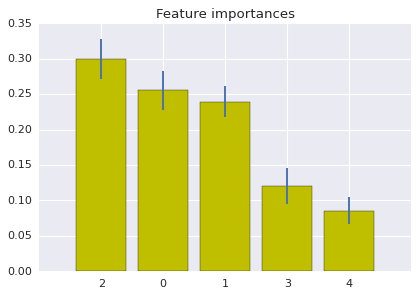

In [937]:
%matplotlib inline
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="y", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [898]:
import seaborn as sns

In [927]:
reordered_labels = []
for f in range(X_train.shape[1]):
    reordered_labels.append(feat_labels[indices[f]])

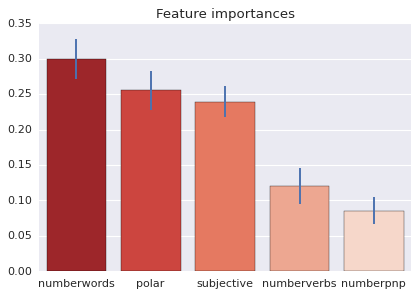

In [949]:
%matplotlib inline
plt.title("Feature importances")
featbars = sns.barplot(reordered_labels, importances[indices], ci=68, palette="Reds_r", yerr=std[indices])
featbars.figure.savefig('feature_importances.png', dpi=300)

In [951]:
popular_tweets.columns = [feat_labels]
nonpopular_tweets.columns = [feat_labels]

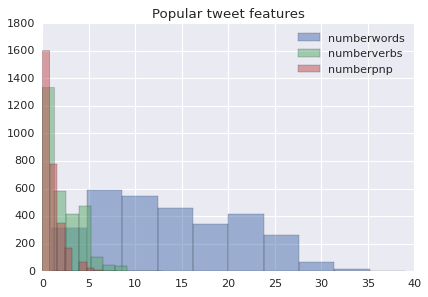

In [1064]:
plt.figure()
plt.title("Popular tweet features")
plt.hist(popular_tweets.numberwords[:3000], alpha=0.5, label=reordered_labels[0])
plt.hist(popular_tweets.numberverbs[:3000], alpha=0.5, label=reordered_labels[3])
plt.hist(popular_tweets.numberpnp[:3000], alpha=0.5, label=reordered_labels[4])
plt.legend()
#plt.show()
plt.savefig('popxfactor_hist.png', dpi=300)

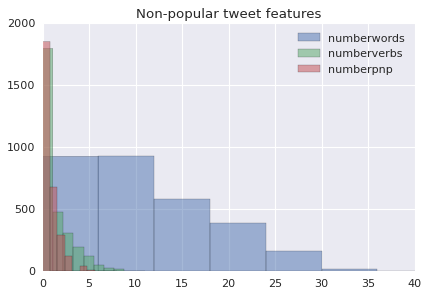

In [1063]:
plt.figure()
plt.xlim(0, 40)
plt.title("Non-popular tweet features")
plt.hist(nonpopular_tweets.numberwords[:3000], alpha=0.5, label=reordered_labels[0])
plt.hist(nonpopular_tweets.numberverbs[:3000], alpha=0.5, label=reordered_labels[3])
plt.hist(nonpopular_tweets.numberpnp[:3000], alpha=0.5, label=reordered_labels[4])
plt.legend()
#plt.show()
plt.savefig('nonpopxfactor_hist.png', dpi=300)

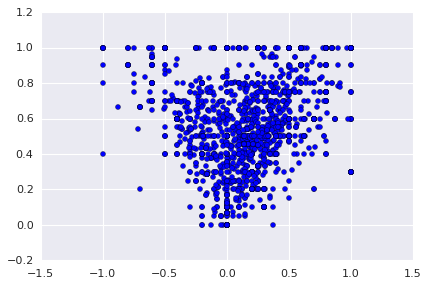

In [1034]:
plt.scatter(popular_tweets.polar, popular_tweets.subjective)

In [1010]:
nonpopular_tweets.numberwords[:1000]

1000

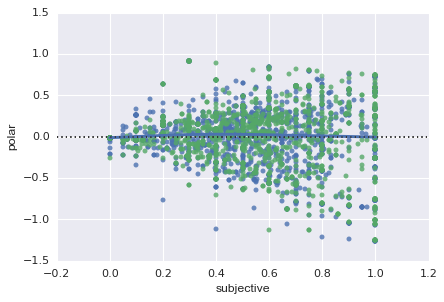

In [1076]:
sns.residplot(popular_tweets.subjective[:3000], popular_tweets.polar[:3000], lowess=True)
sns.residplot(nonpopular_tweets.subjective[:3000], nonpopular_tweets.polar[:3000], lowess=True)

In [1066]:
from pandas.tools.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133695510>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13a809910>]], dtype=object)

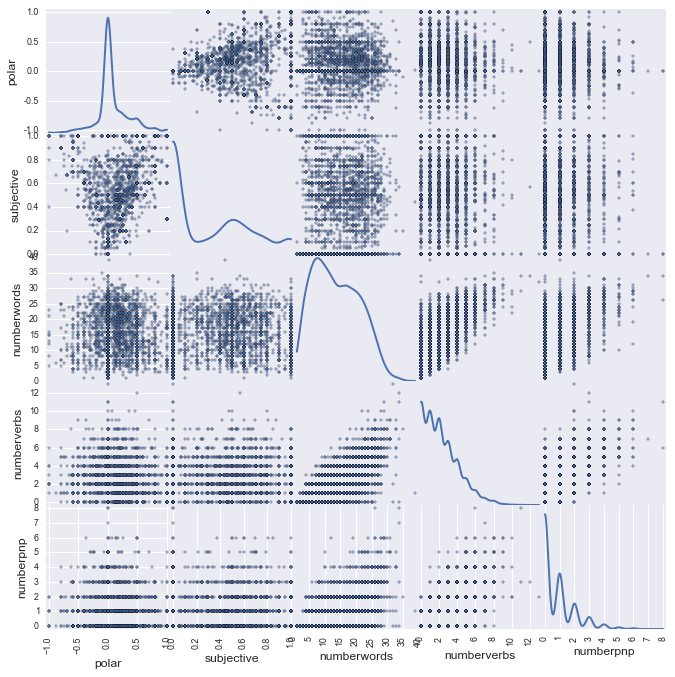

In [1069]:
scatter_matrix(popular_tweets, diagonal='kde', figsize=(10, 10))

In [1223]:
fp = forest.predict(X_test[0, :])

In [1226]:
dir(forest)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_get_param_names',
 '_make_estimator',
 '_set_oob_score',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'class_weight',
 'classes_',
 'criterion',
 'estimator_params',
 'estimators_',
 'feature_importances_',
 'fit',
 'fit_transform',
 'get_params',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_estimators',
 'n_features_',
 'n_jobs',
 'n_outputs_',
 'oob_score',
 'predict',
 'predict_log